Loading Data 

In [2]:
import os
import pandas as pd
import numpy as np

def load_data_from_files(data_dir):
    all_data = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            # Extract metadata from filename
            collection_id, step_info, _ = filename.split('_', 2)
            step_number = ''.join(filter(str.isdigit, step_info))
            foot = 'R' if 'R' in step_info else 'L'
            filepath = os.path.join(data_dir, filename)

            df = pd.read_csv(filepath) 

            df['collection_id'] = collection_id + '_' + str(step_number) + '_' + foot  
            df['filename'] = filename  # Keep track of the file
            df['time'] = pd.to_datetime(df['time'])  # Ensure 'time' column is in datetime format
            df['elapsed_time'] = (df['time'] - df['time'].min()).dt.total_seconds()
            df['gyroscope_magnitude'] = np.sqrt(df['gyroscope_x']**2 + df['gyroscope_y']**2 + df['gyroscope_z']**2)
            df['accelerometer_magnitude'] = np.sqrt(df['accelerometer_x']**2 + df['accelerometer_y']**2 + df['accelerometer_z']**2)
            cols = ['collection_id', 'elapsed_time', 'gyroscope_x', 'gyroscope_y', 
                    'gyroscope_z', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'phase', 'gyroscope_magnitude', 'accelerometer_magnitude'] # , 'foot', 'filename']
            df = df[cols] 
            # df = df[df['phase'] != 0]
            all_data.append(df) 
    return pd.concat(all_data, ignore_index=True)

data_dir = '../csv_output_with_phases'  # Replace with your directory
data = load_data_from_files(data_dir) 

### Choose the lag size
AFC 왜 썼는지 설명 


AFC plot 
- The ACF plot shows the non-stationarity of the data, thus we might need to use time series data techniques such as lagged features or windowing.  
- In ACF, the blue region shows the 95% confidence interval of the correlation of the target values, thus the points that are outside of the blue region are statistically significant. 
- The cut-off point is where the ACF curve crosses the blue line, and the lag at which the ACF curve crosses the blue line is the optimal lag; choose the lag size between 15~20. 

- It can also be seen through the magnitude plot that the phases have patterns as time elapses. 


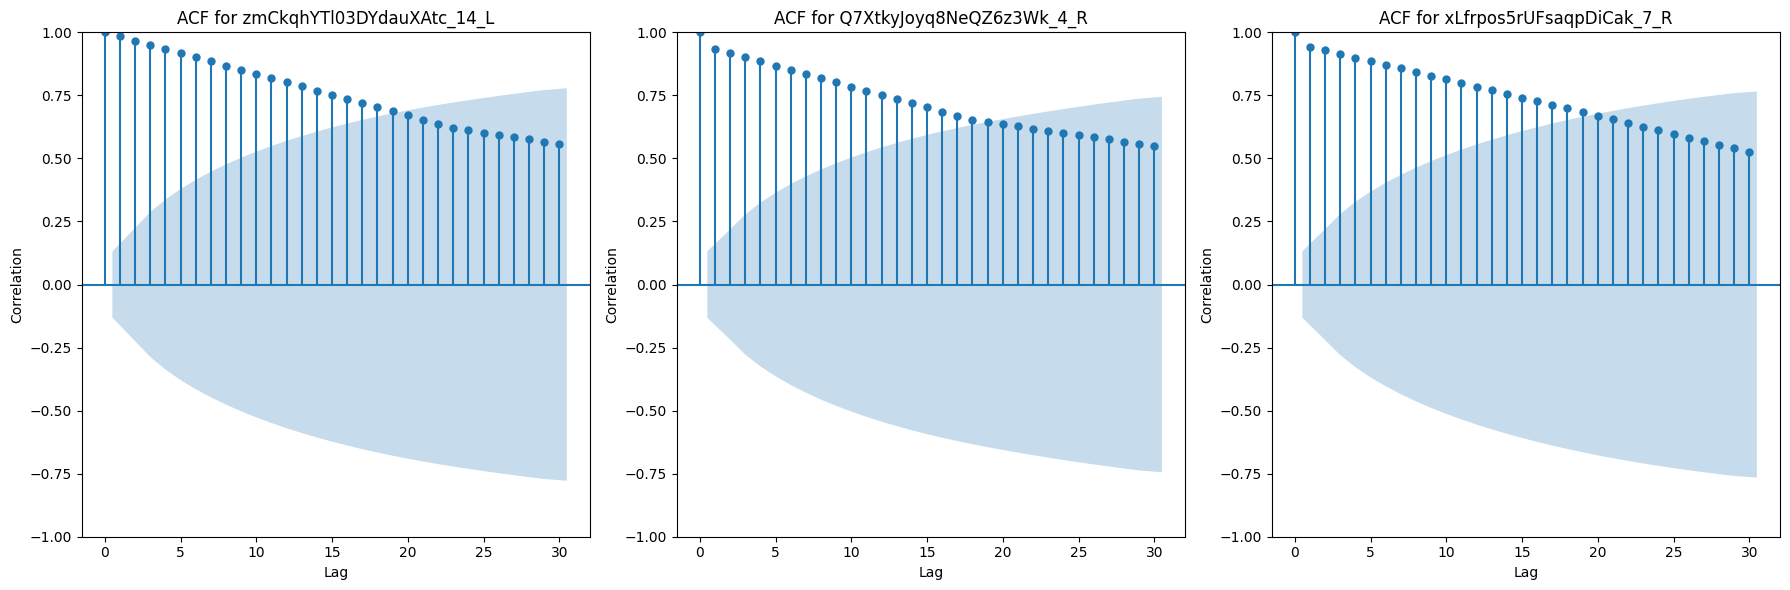

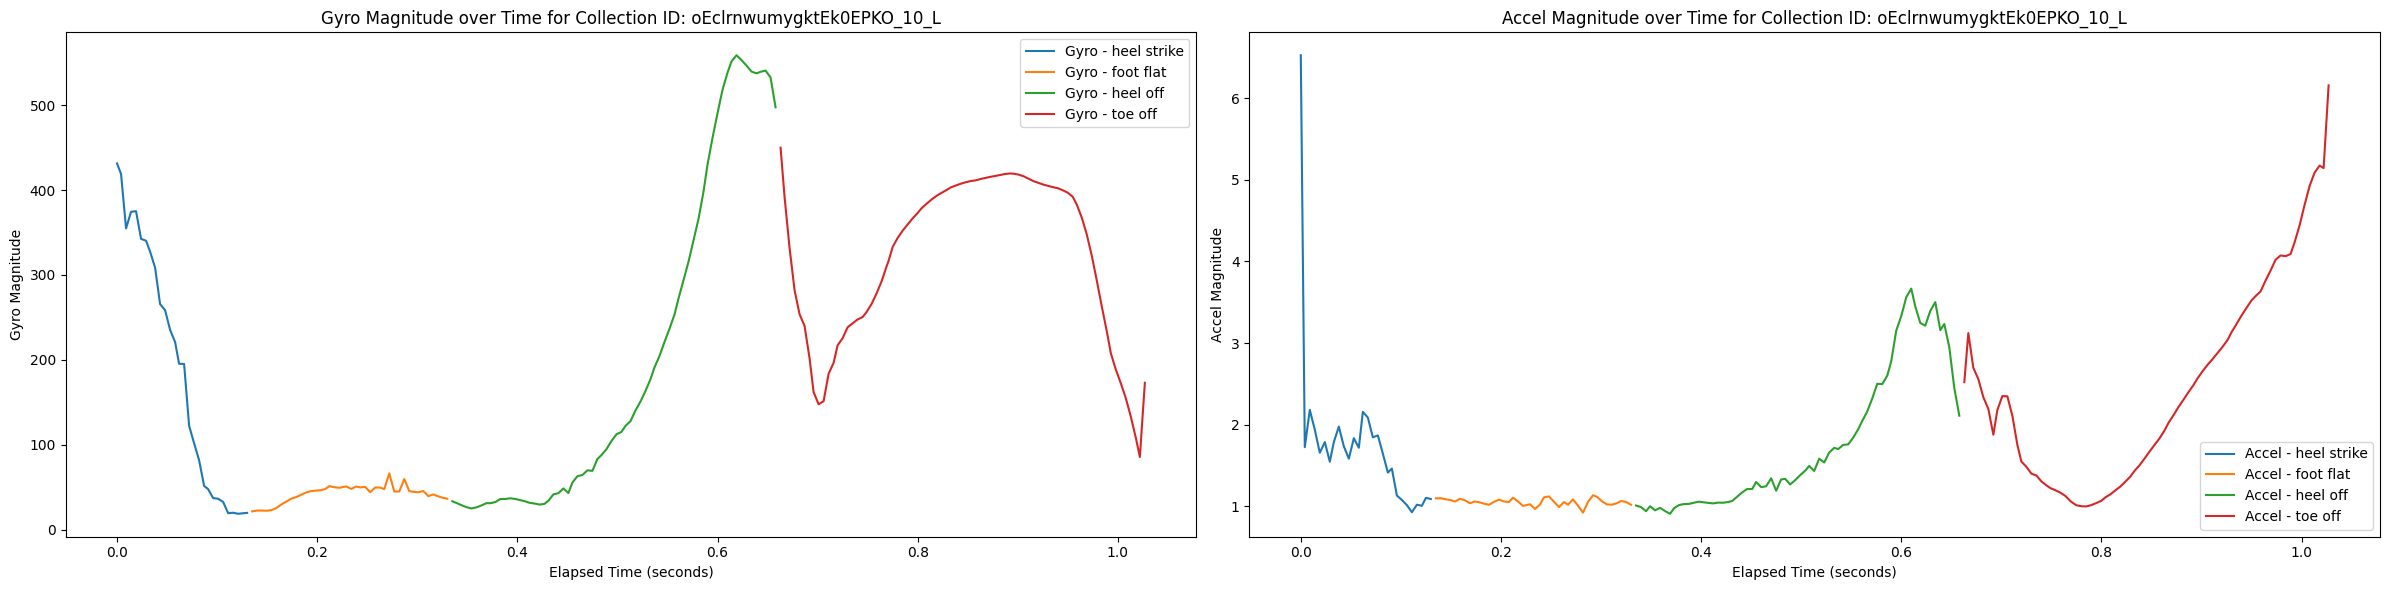

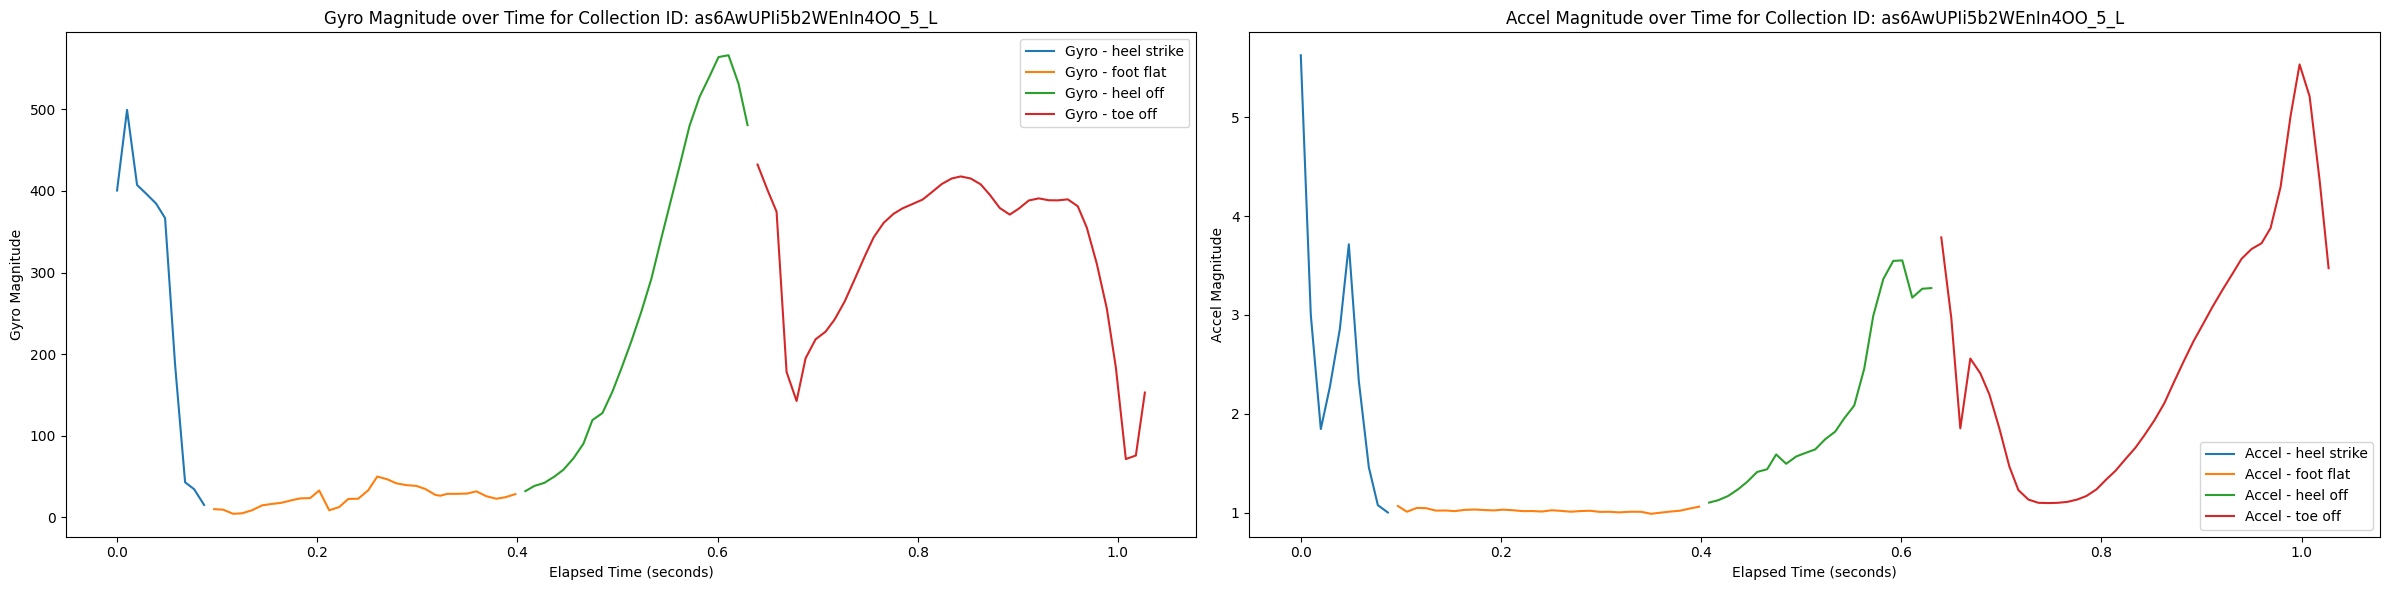

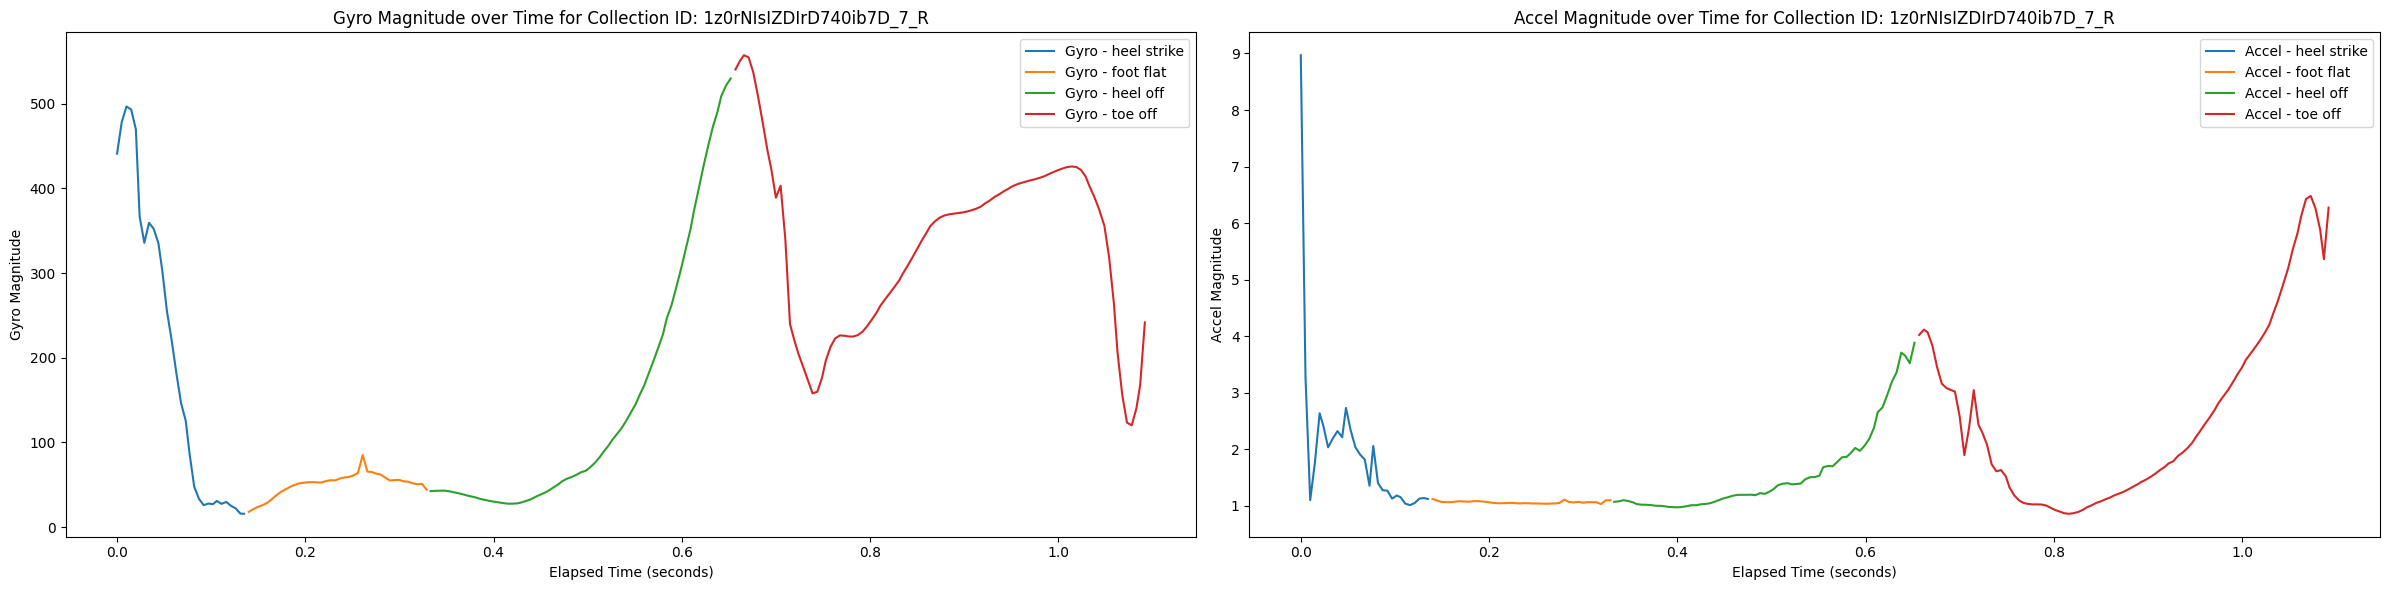

In [3]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf 

def get_three_random_data(data):
    first_three_collection_ids = np.random.choice(data['collection_id'].unique(), 3, replace=False)
    first_three_collection_data = data[data['collection_id'].isin(first_three_collection_ids)].dropna()
    return first_three_collection_data, first_three_collection_ids

def ACF_three_random_data(data, lag = 50):
    first_three_collection_data, first_three_collection_ids = get_three_random_data(data)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for i, collection_id in enumerate(first_three_collection_ids):
        first_target = first_three_collection_data[first_three_collection_data['collection_id'] == collection_id]['phase']
        plot_acf(first_target, lags=lag, ax=axes[i], title=f"ACF for {collection_id}")
        axes[i].set_xlabel("Lag")
        axes[i].set_ylabel("Correlation")
    plt.tight_layout()
    plt.show()

def viz_magnitude_three_random_data(data):

    first_three_collection_data, first_three_collection_ids = get_three_random_data(data) 

    # Define phase labels
    phase_labels = {
        0: 'no event',
        1: 'heel strike',
        2: 'foot flat',
        3: 'heel off',
        4: 'toe off'
    }

    # Iterate over each collection_id
    collection_ids = first_three_collection_data['collection_id'].unique()

    for collection_id in collection_ids:
        collection_data = first_three_collection_data[first_three_collection_data['collection_id'] == collection_id]
        
        # Create subplots for gyro_magnitude and accel_magnitude
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
        
        # Plot gyro_magnitude over time for each collection_id with different colors for each phase
        phases = collection_data['phase'].unique()
        for phase in phases:
            phase_data = collection_data[collection_data['phase'] == phase]
            ax1.plot(phase_data['elapsed_time'], phase_data['gyroscope_magnitude'], label=f'Gyro - {phase_labels[phase]}')

        ax1.set_xlabel('Elapsed Time (seconds)')
        ax1.set_ylabel('Gyro Magnitude')
        ax1.set_title(f'Gyro Magnitude over Time for Collection ID: {collection_id}')
        ax1.legend()

        # Plot accel_magnitude over time for each collection_id with different colors for each phase
        for phase in phases:
            phase_data = collection_data[collection_data['phase'] == phase]
            ax2.plot(phase_data['elapsed_time'], phase_data['accelerometer_magnitude'], label=f'Accel - {phase_labels[phase]}')

        ax2.set_xlabel('Elapsed Time (seconds)')
        ax2.set_ylabel('Accel Magnitude')
        ax2.set_title(f'Accel Magnitude over Time for Collection ID: {collection_id}')
        ax2.legend()

        plt.tight_layout()
        plt.show()

ACF_three_random_data(data, lag = 30)
viz_magnitude_three_random_data(data)

### preprocess data
어떻게 프로세스 했는지 설명  
scaling the data, drop rows with no event, and encode the target labels

In [4]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def preprocess_data(data):
    # Define features and target
    features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_magnitude', 'accelerometer_magnitude']
    target = 'phase'

    # Drop rows with missing values
    data = data.dropna(subset=features + [target])

    # Drop rows with no event 
    data = data[data[target] != 0] 

    # Subtract the phase by 1 : XGboost takes a value from 0 ~ (num_class-1)
    data[target] = data[target] - 1 

    # Normalize features
    scaler = MinMaxScaler()
    data.loc[:, features] = scaler.fit_transform(data[features])

    # Encode target labels
    label_encoder = LabelEncoder()
    data.loc[:, target] = label_encoder.fit_transform(data[target])

    return data, label_encoder

scaled_data, label_encoder = preprocess_data(data)

In [5]:
len(scaled_data['collection_id'].unique())

2324

### Add lagged features
파라미터 설명 

In [6]:
class Lagged_DataSet():
    def __init__(self, data, features, target, window_size=50): 
        self.data = data 
        self.features = features 
        self.len_features = len(self.features) 
        self.target = target 
        self.window_size = window_size

        self.collection_id = 0

        self.X = pd.DataFrame()
        self.y = pd.DataFrame()
        self.collection_ids = pd.DataFrame()

        for collection_id in self.data['collection_id'].unique()[:20]:
            collection_data = self.data[self.data['collection_id'] == collection_id].sort_values(by='elapsed_time')
            # collection_data = collection_data[self.features + ['phase'] + ['collection_id']] 
            collection_data = collection_data[self.features + ['phase']] 
            collection_length = len(collection_data)
            if collection_length > self.window_size: 
                lagged_features = {}
                for j in range(self.len_features):
                    for i in range(1, self.window_size):
                        lagged_features[f'{self.features[j]}_lag{i}'] = collection_data[self.features[j]].shift(i)
                lagged_df = pd.DataFrame(lagged_features)
                collection_data = pd.concat([collection_data, lagged_df], axis=1)

            collection_data.dropna(inplace=True) 
            # collection_data['collection_id'] = self.collection_id

            collection_data = collection_data.drop(columns=self.features)
            collection_data = collection_data.dropna(axis=1, how='any')
            
            self.X = pd.concat([self.X, collection_data.drop(columns=[self.target])], ignore_index=True)
            # self.X = pd.concat([self.X, collection_data.drop(columns=['phase', 'collection_id'])], ignore_index=True)
            self.y = pd.concat([self.y, collection_data[[self.target]]], ignore_index=True)
            # self.collection_ids = pd.concat([self.collection_ids, collection_data[['collection_id']]], ignore_index=True) 

            self.collection_id += 1  
        
        self.X_df = self.X.copy()
        self.y_df = self.y.copy()
        # self.collection_ids_df = self.collection_ids.copy()
        
        self.X = self.X_df.values
        self.y = self.y_df.values 
        # self.collection_ids = self.collection_ids_df.values 

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx] 

features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
            'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
target = 'phase'
sequence_length = 15  # hyperparameter to be tuned; 15~20 is optimal

dataset = Lagged_DataSet(scaled_data, features, target, sequence_length)  

In [7]:
print(len(dataset.X), len(dataset.y))

4296 4296


### Training the model

XGboost 설명   
XGBoost 파라미터 설명 

In [9]:
from xgboost import XGBClassifier # scikit-learn wrapper
import xgboost as xgb
from sklearn.model_selection import GroupKFold, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, classification_report

def train_XGBoost(dataset, xgb_grid_param, random_state=42, test_size=0.3):

    xgb_clf = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', num_class=4, early_stopping_rounds=100, n_jobs=16)
    skf = StratifiedKFold(n_splits=3)

    X_train, x_test, Y_train, y_test = train_test_split(dataset.X, dataset.y, test_size=test_size, random_state=random_state) 
    X_val, x_test, Y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=random_state)

    xgb_grid = GridSearchCV(
        xgb_clf, 
        param_grid=xgb_grid_param, 
        scoring="accuracy", 
        cv=skf, 
        n_jobs=1, # n_jobs for grid search 
        verbose=10
        )
    
    xgb_grid.fit(
        X_train, Y_train, 
        eval_set=[(X_val, Y_val)],
        verbose=0
        )

    model = xgb_grid.best_estimator_
    print(xgb_grid.best_params_)

    print('cacluating accuracy...')
    train_accuracy = round(accuracy_score(Y_train, model.predict(X_train)), 2)
    val_accuracy = round(accuracy_score(y_test, model.predict(x_test) ), 2)
    train_mlogloss = log_loss(Y_train, model.predict_proba(X_train))
    val_mlogloss = log_loss(y_test, model.predict_proba(x_test))

    print(f"Train Accuracy: {train_accuracy:.2f}, Validation Accuracy: {val_accuracy:.2f}, Train MSE: {train_mlogloss:.2f}, Validation MSE: {val_mlogloss:.2f}") 

    return model

# scikit-learn wrapper parameters 
xgb_grid_param = {
    'objective': ['multi:softmax'],
    'eval_metric': ['mlogloss'],
    'num_class': [4],
    'learning_rate': [0.05, 0.1, 0.15],  # Use 'learning_rate' instead of 'eta' / default 0.1
    'n_estimators': [100,200,300], # number of trees / default 200
    'max_depth': [3, 5, 7, 9], # max tree depth / defualt 5
    # 'min_child_weight': [1], # if value too high, chance of underfitting / defautl 1 
    # 'reg_lambda': [1], # L2 regularization term on weights / default 1
    # 'reg_alpha': [0], # L1 regularization term on weights / default 0
    # 'gamma': [0, 1], # minimum loss reduction required to make a further partition on a leaf node of the tree / default 0 
    # 'early_stopping_rounds': [100], # number of rounds to wait before early stopping / default 0 
    'n_jobs': [16], # number of parallel threads for the model / default 1
    # 'device': ['cuda'], # When using GPU
    # 'tree_method': ['hist'], # When using GPU
}

model = train_XGBoost(dataset, xgb_grid_param, random_state=42) 

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START eval_metric=mlogloss, learning_rate=0.05, max_depth=3, n_estimators=100, n_jobs=16, num_class=4, objective=multi:softmax
[CV 1/3; 1/36] END eval_metric=mlogloss, learning_rate=0.05, max_depth=3, n_estimators=100, n_jobs=16, num_class=4, objective=multi:softmax;, score=0.929 total time=   0.6s
[CV 2/3; 1/36] START eval_metric=mlogloss, learning_rate=0.05, max_depth=3, n_estimators=100, n_jobs=16, num_class=4, objective=multi:softmax
[CV 2/3; 1/36] END eval_metric=mlogloss, learning_rate=0.05, max_depth=3, n_estimators=100, n_jobs=16, num_class=4, objective=multi:softmax;, score=0.920 total time=   0.5s
[CV 3/3; 1/36] START eval_metric=mlogloss, learning_rate=0.05, max_depth=3, n_estimators=100, n_jobs=16, num_class=4, objective=multi:softmax
[CV 3/3; 1/36] END eval_metric=mlogloss, learning_rate=0.05, max_depth=3, n_estimators=100, n_jobs=16, num_class=4, objective=multi:softmax;, score=0.931 total time= 